In [1]:
import IPython
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly as py
from plotly.offline import download_plotlyjs
import pylab
import scipy
import seaborn as sns
import sklearn
from sklearn import *
import statsmodels as sm

np.random.seed(1337)

%matplotlib inline

IPython.core.display.display(IPython.core.display.HTML(
    "<style>.container { width:90% !important; }</style>"))

sns.set(font_scale=1.3)
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette('muted'))

pd.options.display.max_colwidth = 30
pd.options.display.float_format = '{:,.3f}'.format

py.offline.init_notebook_mode(connected=True)

## Load the data

In [2]:
movies = pd.read_csv('data/movies_clean.csv')
ratings = pd.read_csv('data/ratings_train.csv')

# Calculate similarities on top movies

## Select movies to calculate similarity on

In [3]:
n_movies = 40

In [4]:
movie_rating_counts = pd.DataFrame(ratings.groupby(['movie_id']).user_id.count())
movie_rating_counts.columns = ['rating_count']
movies = movies.merge(movie_rating_counts, left_on='movie_id', right_index=True)
top_movie_ids = movies.sort_values('rating_count', ascending=False).head(n_movies).movie_id.tolist()
movies.sort_values('rating_count', ascending=False).head(n_movies)[['movie_id', 'title', 'rating_count']]

,movie_id,title,rating_count
293,296,Pulp Fiction (1994),53894
352,356,Forrest Gump (1994),53040
315,318,"Shawshank Redemption, The ...",50791
587,593,"Silence of the Lambs, The ...",50666
476,480,Jurassic Park (1993),47722
257,260,Star Wars: Episode IV - A ...,43574
108,110,Braveheart (1995),43177
583,589,Terminator 2: Judgment Day...,41635
2486,2571,"Matrix, The (1999)",41064
0,1,Toy Story (1995),39894


## Select users who have enough ratings

In [5]:
user_rating_counts = ratings[ratings.movie_id.isin(top_movie_ids)].groupby('user_id').movie_id.count()
user_ids = user_rating_counts[user_rating_counts >= (n_movies/2)].index.tolist()
print('number of users who have enough ratings: ', len(user_ids))

number of users who have enough ratings:  22334


## Prepare the data for similarity computation

In [6]:
# get dense rating matrix
r = ratings[(ratings.user_id.isin(user_ids)) & (ratings.movie_id.isin(top_movie_ids))][['user_id', 'movie_id', 'rating']]
r = r.pivot(index='user_id', columns='movie_id').sort_index()
print(r.shape)
r.head(10)

(22334, 40)


rating                                                        ...   \
movie_id   1     32    47    50    110   150   260   296   318   344   ...    
user_id                                                                ...    
11        4.500 5.000   nan   nan 4.000 5.000 5.000 3.500 5.000 3.500  ...    
24        4.000   nan 4.000 5.000 4.000 3.000 5.000 5.000 5.000 5.000  ...    
25          nan 3.500 3.000 3.500 3.500   nan   nan 4.000 4.000 3.500  ...    
54        4.000 5.000 4.000 4.000 5.000   nan 4.000   nan 5.000 1.000  ...    
58        5.000   nan 5.000 5.000 5.000   nan   nan 5.000 5.000   nan  ...    
69          nan 5.000   nan 4.000   nan   nan 5.000   nan   nan 4.000  ...    
90        3.500   nan 4.500   nan   nan 3.500 3.500 3.500 4.000 3.500  ...    
91        4.000 4.000   nan 3.500 5.000   nan 4.500 3.500 4.000 2.500  ...    
96        3.500 4.000 4.000 3.000   nan   nan 4.000 4.500 4.500   nan  ...    
110         nan   nan   nan   nan   nan 5.000   nan   nan 4.000 3.000  ...    

                                                                      
movie_id  1198  1210  1270  1580  2028  2571  2762  2858  2959  4993  
user_id                                                               
11       4.000   nan 5.000   nan 5.000   nan   nan   nan 4.500 5.000  
24         nan 5.000 4.000 5.000 5.000 5.000 5.000 5.000 5.000   nan  
25       3.500   nan   nan 1.500 3.500 3.500   nan   nan 4.000 3.500  
54         nan 3.000   nan   nan 5.000 5.000   nan 5.000   nan   nan  
58       4.000   nan   nan 4.000 5.000 5.000 5.000 4.500 5.000 5.000  
69       5.000 5.000 3.000   nan   nan   nan   nan   nan   nan   nan  
90         nan 4.000   nan   nan 2.500 2.000 4.000 5.000 2.000   nan  
91       5.000   nan 4.000   nan 4.000 3.500 4.000 4.500 5.000 5.000  
96       4.500   nan 4.500   nan 4.000 4.500 4.500   nan   nan 4.000  
110      4.000   nan 3.500   nan 4.500 1.500 5.000 0.500 1.000   nan  

[10 rows x 40 columns]

In [7]:
# normalize ratings by user ratings average
user_mean_ratings = ratings[ratings.user_id.isin(user_ids)][['user_id', 'rating']].groupby('user_id').rating.mean().sort_index()
print(user_mean_ratings.head(10))
for movie_id in r.columns:
    r[movie_id] -= user_mean_ratings.values
r.fillna(0, inplace=True)
print(r.shape)
r.head(10)

user_id
11    3.889
24    3.370
25    3.635
54    3.421
58    4.142
69    3.148
90    3.515
91    3.378
96    3.454
110   3.788
Name: rating, dtype: float64
(22334, 40)


rating                                                                \
movie_id   1      32     47     50     110    150    260    296   318    344    
user_id                                                                         
11        0.611  1.111  0.000  0.000  0.111  1.111  1.111 -0.389 1.111 -0.389   
24        0.630  0.000  0.630  1.630  0.630 -0.370  1.630  1.630 1.630  1.630   
25        0.000 -0.135 -0.635 -0.135 -0.135  0.000  0.000  0.365 0.365 -0.135   
54        0.579  1.579  0.579  0.579  1.579  0.000  0.579  0.000 1.579 -2.421   
58        0.858  0.000  0.858  0.858  0.858  0.000  0.000  0.858 0.858  0.000   
69        0.000  1.852  0.000  0.852  0.000  0.000  1.852  0.000 0.000  0.852   
90       -0.015  0.000  0.985  0.000  0.000 -0.015 -0.015 -0.015 0.485 -0.015   
91        0.622  0.622  0.000  0.122  1.622  0.000  1.122  0.122 0.622 -0.878   
96        0.046  0.546  0.546 -0.454  0.000  0.000  0.546  1.046 1.046  0.000   
110       0.000  0.000  0.000  0.000  0.000  1.212  0.000  0.000 0.212 -0.788   

          ...                                                                  \
movie_id  ...     1198   1210   1270   1580   2028   2571  2762   2858   2959   
user_id   ...                                                                   
11        ...    0.111  0.000  1.111  0.000  1.111  0.000 0.000  0.000  0.611   
24        ...    0.000  1.630  0.630  1.630  1.630  1.630 1.630  1.630  1.630   
25        ...   -0.135  0.000  0.000 -2.135 -0.135 -0.135 0.000  0.000  0.365   
54        ...    0.000 -0.421  0.000  0.000  1.579  1.579 0.000  1.579  0.000   
58        ...   -0.142  0.000  0.000 -0.142  0.858  0.858 0.858  0.358  0.858   
69        ...    1.852  1.852 -0.148  0.000  0.000  0.000 0.000  0.000  0.000   
90        ...    0.000  0.485  0.000  0.000 -1.015 -1.515 0.485  1.485 -1.515   
91        ...    1.622  0.000  0.622  0.000  0.622  0.122 0.622  1.122  1.622   
96        ...    1.046  0.000  1.046  0.000  0.546  1.046 1.046  0.000  0.000   
110       ...    0.212  0.000 -0.288  0.000  0.712 -2.288 1.212 -3.288 -2.788   

                 
movie_id   4993  
user_id          
11        1.111  
24        0.000  
25       -0.135  
54        0.000  
58        0.858  
69        0.000  
90        0.000  
91        1.622  
96        0.546  
110       0.000  

[10 rows x 40 columns]

## Calculate similarities

[ 9 12 12 12 10 14 11 12 12  1 10  8  1  3  5 15 16  2 12  8 11 17 18 12
  8 12  6  4 12 11 11 11 11  7 10 12 13 12 12 11]


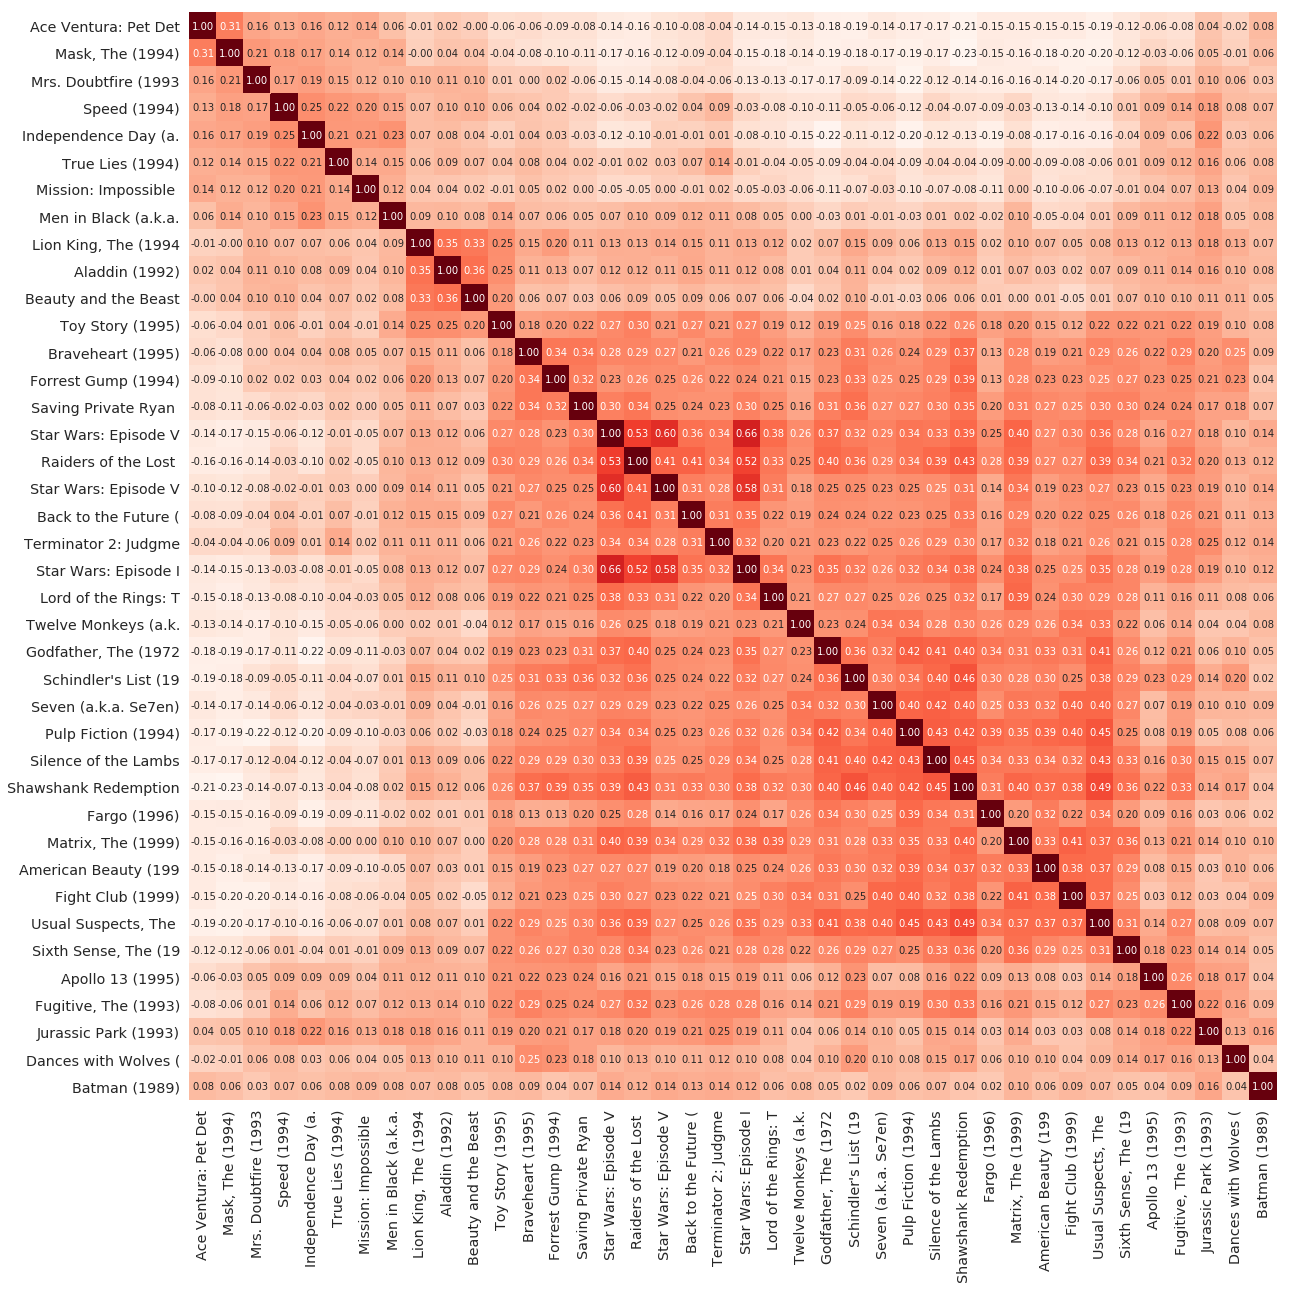

In [8]:
# calculate similarities
s = sklearn.metrics.pairwise.cosine_similarity(r.T)
titles = [title[:20] for title in movies[movies.movie_id.isin(top_movie_ids)].title.tolist()]

# hierarchical clustering to move similar items next to each other for better visualization
t = np.round((1 - s) / np.max(1 - s), decimals=3)
labels = scipy.cluster.hierarchy.fcluster(
            scipy.cluster.hierarchy.linkage(
                scipy.spatial.distance.squareform(t),
                method='average'),
            0.58,
            criterion='distance')
print(labels)
for i in range(n_movies):
    for j in range(i+1, n_movies):
        if labels[i] > labels[j]:
            labels[i], labels[j] = labels[j], labels[i]
            titles[i], titles[j] = titles[j], titles[i]
            
            tmp = np.copy(s[i,:])
            s[i,:] = s[j,:]
            s[j,:] = tmp
            
            tmp = np.copy(s[:,i])
            s[:,i] = s[:,j]
            s[:,j] = tmp

# plot similarity matrix
plt.figure(figsize=(20, 20))
sns.heatmap(
    data=s,
    vmin=np.min(s),
    vmax=np.max(s),
    cbar=False,
    square=True,
    annot=True,
    fmt='.2f',
    xticklabels=titles,
    yticklabels=titles,
    cmap='Reds')
plt.show()

# Find similar items to a movie

In [9]:
def similar_movies(source_movie_id, min_ratings=50, n_results=30):
    # find users that rated the movie
    user_ids = ratings[ratings.movie_id == source_movie_id].user_id.unique()
    print('number of users that rated the movie: ', len(user_ids))
    
    # find movies that have enough ratings among these users
    ratings_by_users = ratings[ratings.user_id.isin(user_ids)]
    movie_rating_counts = ratings_by_users.groupby('movie_id').user_id.count()
    candidate_movie_ids = movie_rating_counts[movie_rating_counts >= min_ratings].index.tolist()
    print('number of candidate movies that have enough ratings: ', len(candidate_movie_ids))
    
    # get dense rating matrix
    r = ratings[(ratings.user_id.isin(user_ids)) & (ratings.movie_id.isin(candidate_movie_ids))][['user_id', 'movie_id', 'rating']]
    r = r.pivot(index='user_id', columns='movie_id').sort_index()

    # normalize ratings by user ratings average
    user_mean_ratings = ratings[ratings.user_id.isin(user_ids)][['user_id', 'rating']].groupby('user_id').rating.mean().sort_index()
    for movie_id in r.columns:
        r[movie_id] -= user_mean_ratings.values
    r.fillna(0, inplace=True)
    
    # compute similarities
    candidates = []
    def cos_sim(a, b):
        return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(a))
    for movie_id in candidate_movie_ids:
        candidates.append({
            'movie_id': movie_id,
            'title': movies[movies.movie_id == movie_id].values[0][1],
            'similarity': cos_sim(r[('rating', source_movie_id)], r[('rating', movie_id)])})
    candidates = pd.DataFrame(candidates)
    
    #return results
    return candidates.sort_values(by='similarity', ascending=False).head(n_results)[['movie_id', 'title', 'similarity']]

In [10]:
similar_movies(3676, min_ratings=30)

number of users that rated the movie:  2068
number of candidate movies that have enough ratings:  6054


,movie_id,title,similarity
2461,3676,Eraserhead (1977),1.000
1343,2076,Blue Velvet (1986),0.219
3201,4848,Mulholland Drive (2001),0.189
774,1206,"Clockwork Orange, A (1971)",0.185
593,924,2001: A Space Odyssey (1968),0.168
974,1464,Lost Highway (1997),0.149
89,111,Taxi Driver (1976),0.138
502,750,Dr. Strangelove or: How I ...,0.132
824,1258,"Shining, The (1980)",0.131
1516,2313,"Elephant Man, The (1980)",0.116
